# Aplikacja Tomografu
## Paweł Mazurkiewicz 156145
## Filip Michalski 155947

## Import potrzebnych bibliotek

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import math
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage.io import imread
from datetime import datetime

from save_dicom import save_as_dicom

## Konwerter plików dicom

In [2]:
image_dir = "./images"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

# --- Widgety do wyboru pliku i wprowadzenia danych
file_dropdown = widgets.Dropdown(options=image_files, description="Obraz:")
patient_name = widgets.Text(value="Jan Kowalski", description="Imię i nazwisko:")
patient_id = widgets.Text(value="123456", description="ID pacjenta:")
study_date = widgets.Text(value=datetime.today().strftime("%Y%m%d"), description="Data (YYYYMMDD):")
comments = widgets.Text(value="Brak komentarza", description="Komentarz:")
save_button = widgets.Button(description="Zapisz jako DICOM", button_style='success')

output = widgets.Output()

def on_save_clicked(b):
    with output:
        output.clear_output()
        file_path = os.path.join(image_dir, file_dropdown.value)
        img = imread(file_path, as_gray=True)  # wczytanie w odcieniach szarości
        
        # Dane pacjenta
        print(patient_name.value)
        patient_data = {
            "PatientName": patient_name.value,
            "PatientID": patient_id.value,
            "ImageComments": comments.value,
        }

        # Nazwa wyjściowego pliku
        dicom_filename = os.path.splitext(file_dropdown.value)[0] + ".dcm"
        output_path = os.path.join(image_dir, dicom_filename)
        
        # Zapis
        save_as_dicom(output_path, img, patient_data)
        
        print(f"✅ Plik DICOM zapisany: {output_path}")
        print(f"🗓️ Data badania: {study_date.value}")
        plt.imshow(img, cmap='gray')
        plt.title("Zapisany obraz")
        plt.axis("off")
        plt.show()

save_button.on_click(on_save_clicked)

# --- Wyświetlenie interfejsu
display(widgets.VBox([
    file_dropdown,
    patient_name,
    patient_id,
    study_date,
    comments,
    save_button,
    output
]))

## Funkcja Algorytmu Bresenhama oraz funkcje wiązki emiter -> detektor
### **Funkcja: `bresenham(x0, y0, x1, y1)`**

Funkcja ta implementuje algorytm Bresenhama, służący do wyznaczania pikesli, które w przybliżeniu tworzą prostą między dwoma zadanymi punktami przez które będzie przechodzić wiązka z emitera do detektora. Algorytm ten cechuje się efektywnością oraz tym, że operuje wyłącznie na liczbach całkowitych poprzez uproszczenia, co sprawia, że jest dobrze dopasowany do reprezentacji obrazu w postaci siatki pikseli.

W zależności od kierunku linii, funkcja automatycznie przestawia współrzędne tak, aby zawsze iterować po dłuższej osi. Dla każdego kolejnego kroku generowane są współrzędne `(x, y)`, które można traktować jako kolejne piksele leżące na trasie promienia.


### **Funkcja: `simulate_ray(image, x_e, y_e, x_d, y_d)`**

Funkcja służy do symulowania przejścia promienia przez macierz złożoną z pikseli. Jej zadaniem jest wyznaczenie całkowitej sumy intensywności pikseli, przez które przechodzi dany promień, łączący punkt emisji `(x_e, y_e)` z punktem detekcji `(x_d, y_d)`.

W pierwszym kroku funkcja określa rozmiary obrazu, a następnie za pomocą algorytmu `bresenham` uzyskuje współrzędne wszystkich pikseli leżących na trasie wiązki. Jeśli punkt znajduje się wewnątrz obrazu, jego wartość (jasność piksela) jest dodawana do zmiennej `total`.

Zwracana wartość `total` reprezentuje całkowitą „gęstość” napotkaną przez promień — jest to symulowana wartość odczytu z detektora. Funkcja jest wykorzystywana do funkcji Radona do wyznaczenia **sinogramu** obrazu.



In [3]:
def bresenham(x0, y0, x1, y1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2 * dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x * xx + y * yx, y0 + x * xy + y * yy
        if D >= 0:
            y += 1
            D -= 2 * dx
        D += 2 * dy
        
def simulate_ray(image, x_e, y_e, x_d, y_d):
    height, width = image.shape
    total = 0

    for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
        if 0 <= x < width and 0 <= y < height:
            total += image[y, x]
    return total

## Wczytanie plików 
Ta część kodu wczytuje wszystkie pliki dicom z folderu `/images`.

Funkcja została wzbogacona o listę rozwijaną w celu dostarczenia przejrzystego interfejsu użytkownika.

In [5]:
folder_path = "./images"

dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))

file_names = [os.path.basename(f) for f in dicom_files]

dropdown = widgets.Dropdown(
    options=file_names,
    description='Plik DICOM:',
    disabled=False,
)

selected_file = None

def on_file_selected(change):
    global selected_file
    selected_file = os.path.join(folder_path, change['new'])
    print(f"Wybrano plik: {selected_file}")

dropdown.observe(on_file_selected, names='value')

display(dropdown)

Dropdown(description='Plik DICOM:', options=('Kropka.dcm', 'CT_ScoutView.dcm', 'SADDLE_PE.dcm', 'CT_ScoutView-…

Wybrano plik: ./images/CT_ScoutView.dcm
Wybrano plik: ./images/Kropka.dcm


### Wizualizacja promieni tomografu oraz wybór jego parametrów

W tym fragmencie kodu przygotowano wizualizację rozkładu promieni w symulowanym układzie tomograficznym. Głównym celem jest umożliwienie interaktywnego sterowania parametrami geometrycznymi układu, takimi jak liczba emiterów i detektorów, rozpiętość ich rozmieszczenia oraz krok kątowy między kolejnymi iteracjami.

#### **Zmienne globalne:**
Na początku inicjowane są zmienne globalne:
- `delta_alpha`: początkowo ustawiony na 1 – oznacza krok kątowy obrotu układu emiterów.
- `num_emiters`, `num_detectors`: liczba emiterów i detektorów ustawiona domyślnie na 500.
- `emitter_span`, `detector_span`: rozpiętość układu emiterów.

#### **Wczytanie i przetworzenie obrazu:**
- Obraz DICOM jest wczytywany przy pomocy biblioteki `pydicom`.
- Następnie piksele obrazu są **normalizowane do zakresu 0–255**, a wynik jest konwertowany do typu `uint8`, by można było go poprawnie wyświetlić jako obraz w skali szarości.
- Obliczane są wymiary obrazu i jego środek (`center_x`, `center_y`), a także promień `R`, który określa odległość emiterów i detektorów od środka obrazu (na przeciwnych krańcach).

#### **Funkcja `draw_rays`:**
Funkcja odpowiada za wizualizację promieni przechodzących przez obraz, przy określonym kącie. Wewnątrz funkcji:
- Aktualizowane są zmienne globalne (przy pomocy `global`), aby późniejsze komórki kodu mogły korzystać z tych wartości.
- W pętli `for` generowane są kolejne pozycje emiterów i detektorów oraz rysowane są czerwone linie reprezentujące promienie.

#### **Interaktywny interfejs:**
Na końcu kodu zastosowano interfejs, który pozwala użytkownikowi dynamicznie zmieniać:
- **liczbę emiterów**,  
- **rozpiętość układu**,  
- **kątowy krok**.

Zmienione wartości od razu aktualizują wizualizację, co daje intuicyjny pogląd na to, jak zmiany w geometrii wpływają na pokrycie obrazu promieniami.
Te zmienne potem są aplikowane do obliczeń sinogramu i rekonstrukcji.

## Wybranie parametrów Tomografu

In [7]:
delta_alpha = 1
num_emiters = 500
num_detectors = 500
emitter_span = 1000
detector_span = 1000
ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)

height, width = normalized.shape
center_x, center_y = width / 2, height / 2
R = math.hypot(width, height)

def draw_rays(num_emit=100, span=500, angle_step=1):
    global delta_alpha, num_emiters, num_detectors, emitter_span, detector_span
    delta_alpha = angle_step
    num_emiters = num_emit
    num_detectors = num_emit
    emitter_span = span
    detector_span = span
    angle_deg=90
    plt.figure(figsize=(6,6))
    plt.imshow(normalized, cmap='gray')
    plt.title(f"Promienie | Kąt: {angle_step}° | Emitery: {num_emit} | Span: {span}")
    
    theta = math.radians(angle_deg)

    # Centralne punkty dla emiterów i detektorów (po przeciwnych stronach)
    x_center_emiter = center_x + R * math.cos(theta)
    y_center_emiter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)

    # Kierunki linii emiterów i detektorów (prostopadle do promienia)
    dir_x = -math.sin(theta)
    dir_y = math.cos(theta)

    for i in range(num_emit):
        s = -span/2 + i * (span / (num_emit - 1))
        x_e = x_center_emiter + s * dir_x
        y_e = y_center_emiter + s * dir_y
        x_d = x_center_detector + s * dir_x
        y_d = y_center_detector + s * dir_y

        # Rysowanie promieni
        plt.plot([x_e, x_d], [y_e, y_d], color='red', alpha=0.3)
    
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.show()
    

# Interaktywny widget
widgets.interact(
    draw_rays,
    num_emit=widgets.IntSlider(min=10, max=500, step=10, value=100, description='Liczba emiterów'),
    span=widgets.FloatSlider(min=50, max=1000, step=10, value=500, description='Span [px]'),
    angle_step=widgets.FloatSlider(min=1, max=30, step=1, value=1, description='Angle step')
);


interactive(children=(IntSlider(value=100, description='Liczba emiterów', max=500, min=10, step=10), FloatSlid…

## Filtrowaniekonwolucyjne (splot)


In [21]:
def convolve_1d(signal, kernel):
    signal_len = len(signal)
    kernel_len = len(kernel)
    pad = kernel_len // 2

    # Odwracamy jądro, jak w klasycznej konwolucji
    kernel = kernel[::-1]

    # Uzupełniamy sygnał zerami po bokach
    padded_signal = np.pad(signal, pad_width=pad, mode='constant', constant_values=0)

    output = np.zeros_like(signal, dtype=np.float64)
    for i in range(signal_len):
        for j in range(kernel_len):
            output[i] += padded_signal[i + j] * kernel[j]
    return output
def filter_sinogram(sinogram):
    # Przykładowy filtr Ram-Lak w wersji uproszczonej
    kernel = np.array([-2, -1, 0, 4, 0, -1, -2])
    kernel = kernel / np.sum(np.abs(kernel))


    num_angles, num_detectors = sinogram.shape
    filtered = np.zeros_like(sinogram)

    for i in range(num_angles):
        projection = sinogram[i, :]
        filtered[i, :] = convolve_1d(projection, kernel)

    return filtered

przelacznik = widgets.ToggleButtons(
    options=['Tak', 'Nie'],
    description='Zastosować filtrowanie?:',
    disabled=False,
    button_style=''  # 'success', 'info', 'warning', 'danger' lub ''
)

# Funkcja, która przypisuje wartość do zmiennej
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global odpowiedz
        odpowiedz = change['new']
        print(f'Wybrano: {odpowiedz}')

# Reagujemy na zmianę wyboru
przelacznik.observe(on_change)

# Wyświetlamy widget
display(przelacznik)



ToggleButtons(description='Zastosować filtrowanie?:', options=('Tak', 'Nie'), value='Tak')

Wybrano: Nie
Wybrano: Tak


(400, 400)


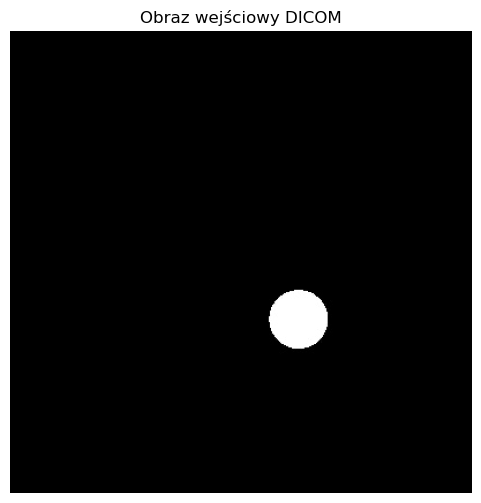

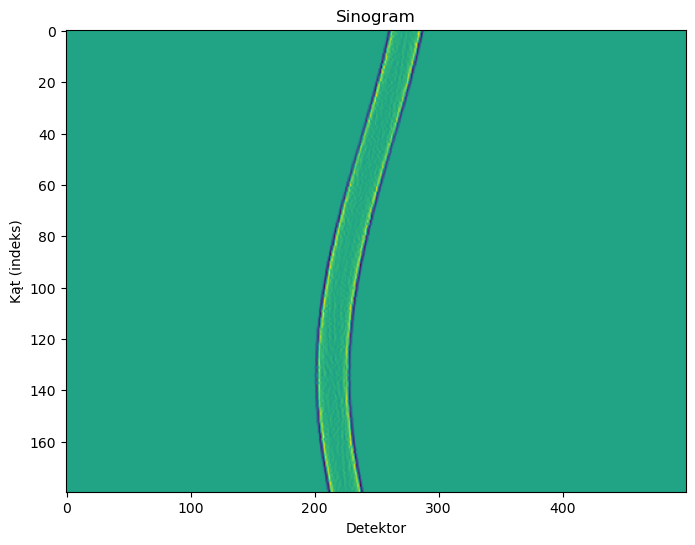

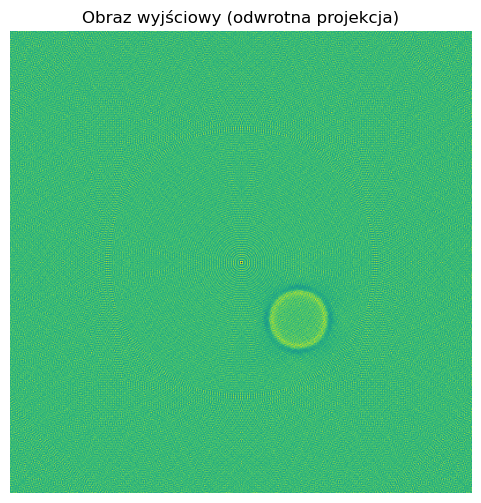

In [31]:
num_angles = int(180 / delta_alpha)
num_emitters = 500
num_detectors = 500

emitter_span = 1000
detector_span = 1000


ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = pixel_array
# normalized = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) *255).astype(np.uint8)
print(normalized.shape)

plt.figure(figsize=(6,6))
plt.imshow(normalized, cmap='gray')
plt.title("Obraz wejściowy DICOM")
plt.axis("off")
plt.show()

height, width = normalized.shape

center_x, center_y = width / 2, height / 2


R = math.hypot(width, height)

sinogram = np.zeros((num_angles, num_detectors))

reconstruction = np.zeros_like(normalized, dtype=np.float64)

# Przetwarzamy każdy kąt
for angle_idx, alpha in enumerate(np.linspace(1, 180, num_angles)):
    #theta - kąt alpha w radianach
    theta = math.radians(alpha)
    
    # Pozycja emitera - na okręgu wokół obrazu
    x_center_emiter = center_x + R * math.cos(theta)
    y_center_emiter = center_y + R * math.sin(theta)

    # Pozycja centralna detektorów (przeciwna strona)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)


    # Kierunek układu detektorów: prostopadły do promienia (wektor jednostkowy)
    det_dir_x = -math.sin(theta)
    det_dir_y = math.cos(theta)

    emiter_dir_x = -math.sin(theta)
    emiter_dir_y = math.cos(theta)

    # Przechodzimy po każdym detektorze
    for det_idx in range(num_detectors):
        

        s = -emitter_span/2 + det_idx * (emitter_span / (num_emiters - 1))
        # pozycja danego emitera
        x_e = x_center_emiter + s * emiter_dir_x
        y_e = y_center_emiter + s * emiter_dir_y

        s = -detector_span/2 + det_idx * (detector_span / (num_detectors - 1))
        # Pozycja danego detektora
        x_d = x_center_detector + s * det_dir_x
        y_d = y_center_detector + s * det_dir_y

        # Symulujemy promień dla danej pary emiter-detektor
        ray_value = simulate_ray(normalized, x_e, y_e, x_d, y_d)
        sinogram[angle_idx, det_idx] = ray_value


        # Odwrotna projekcja (prostą metodą dodajemy wartość promienia do pikseli, które promień przecina)
        # for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
        #     if 0 <= x < width and 0 <= y < height:
        #         reconstruction[y, x] += ray_value

sinogram = filter_sinogram(sinogram)
sinogram = ((sinogram - np.min(sinogram)) / 
                          (np.max(sinogram) - np.min(sinogram)) * 255).astype(np.uint8)
reconstruction = np.zeros_like(normalized, dtype=np.float64)

for angle_idx, alpha in enumerate(np.linspace(1, 180, num_angles)):
    theta = math.radians(alpha)
    x_center_emiter = center_x + R * math.cos(theta)
    y_center_emiter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)

    det_dir_x = -math.sin(theta)
    det_dir_y = math.cos(theta)
    emiter_dir_x = -math.sin(theta)
    emiter_dir_y = math.cos(theta)

    for det_idx in range(num_detectors):
        s = -emitter_span/2 + det_idx * (emitter_span / (num_emitters - 1))
        x_e = x_center_emiter + s * emiter_dir_x
        y_e = y_center_emiter + s * emiter_dir_y

        s = -detector_span/2 + det_idx * (detector_span / (num_detectors - 1))
        x_d = x_center_detector + s * det_dir_x
        y_d = y_center_detector + s * det_dir_y

        ray_value = sinogram[angle_idx, det_idx]

        for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
            if 0 <= x < width and 0 <= y < height:
                reconstruction[y, x] += ray_value

# Normalizacja sinogramu do zakresu 0-255 dla wizualizacji
# sinogram_norm = ((sinogram - sinogram.min()) / (sinogram.max() - sinogram.min()) * 255).astype(np.uint8)
plt.figure(figsize=(8,6))
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title("Sinogram")
plt.xlabel("Detektor")
plt.ylabel("Kąt (indeks)")
plt.show()

# Normalizacja rekonstrukcji
# reconstruction_norm = ((reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min()) * 255).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(reconstruction, cmap='gray')
plt.title("Obraz wyjściowy (odwrotna projekcja)")
plt.axis("off")
plt.show()